In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from joblib import load
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from joblib import dump

In [2]:
#Loading Maximum temperature dataset in csv
max_temp = pd.read_csv("Maximum Temperature.csv", header =0, index_col=None)
max_temp.head()

,,,,,,"LEWISBURG 3 N, WV US (USC00465224)"
Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
1852-09-09,NaN,NaN,NaN,NaN,NaN,NaN
1852-09-10,NaN,NaN,NaN,NaN,NaN,NaN
1852-09-11,NaN,NaN,NaN,0.09,NaN,NaN
1852-09-12,NaN,NaN,NaN,0.15,NaN,NaN


In [3]:
#Modifying/adding column headers where there are no headers
max_temp = pd.read_csv("Maximum Temperature.csv", header =None, names=[
    'Date',
    'TAVG (Degrees Fahrenheit)',
    'TMAX (Degrees Fahrenheit)',
    'TMIN (Degrees Fahrenheit)',
    'PRCP (Inches)',
    'SNOW (Inches)',
    'SNWD (Inches)'
])
max_temp.columns.tolist()
max_temp.head()

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,"LEWISBURG 3 N, WV US (USC00465224)",NaN,NaN,NaN,NaN,NaN,NaN
1,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
2,1852-09-09,NaN,NaN,NaN,NaN,NaN,NaN
3,1852-09-10,NaN,NaN,NaN,NaN,NaN,NaN
4,1852-09-11,NaN,NaN,NaN,0.09,NaN,NaN


In [4]:
#Remove first two rows as headers were repeated and delete unnecessary columns
max_temp = max_temp.iloc[2:].reset_index(drop=True)
max_temp = max_temp.drop(columns = ["TAVG (Degrees Fahrenheit)", "SNWD (Inches)"])

In [5]:
#Convert Date column to year, month and the day
max_temp['Date'] = max_temp['Date'].astype("datetime64[ns]")
max_temp['Date'] = max_temp['Date'].dt.strftime('%Y-%m-%d')
max_temp['Date'] = pd.to_datetime(max_temp['Date'])

In [6]:
#Separate columns for Day, month and the year
max_temp['Day'] = max_temp['Date'].dt.day
max_temp['Month'] = max_temp['Date'].dt.month
max_temp['Year'] = max_temp['Date'].dt.year

In [7]:
# Sort chronologically
df = max_temp.sort_values('Date')

# Ensure the column is numeric
df['TMAX (Degrees Fahrenheit)'] = pd.to_numeric(df['TMAX (Degrees Fahrenheit)'], errors='coerce')
# Fill missing values using the median
df['TMAX (Degrees Fahrenheit)'] = df['TMAX (Degrees Fahrenheit)'].fillna(df['TMAX (Degrees Fahrenheit)'].median())

In [8]:
#Filter for NAN Values
not_nan_rows_df = max_temp[max_temp['TMAX (Degrees Fahrenheit)'].notnull()]
not_nan_rows_df

,Date,TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),Day,Month,Year
17386,1900-04-17,65,52,NaN,NaN,17,4,1900
17387,1900-04-18,66,54,0.27,NaN,18,4,1900
17388,1900-04-19,74,47,NaN,NaN,19,4,1900
17389,1900-04-20,70,46,0.20,NaN,20,4,1900
17390,1900-04-21,55,48,0.47,NaN,21,4,1900
...,...,...,...,...,...,...,...,...
63225,2025-10-17,71,31,0.00,0.0,17,10,2025
63226,2025-10-18,70,30,0.00,0.0,18,10,2025
63227,2025-10-19,80,31,0.00,0.0,19,10,2025
63228,2025-10-20,71,41,0.35,0.0,20,10,2025


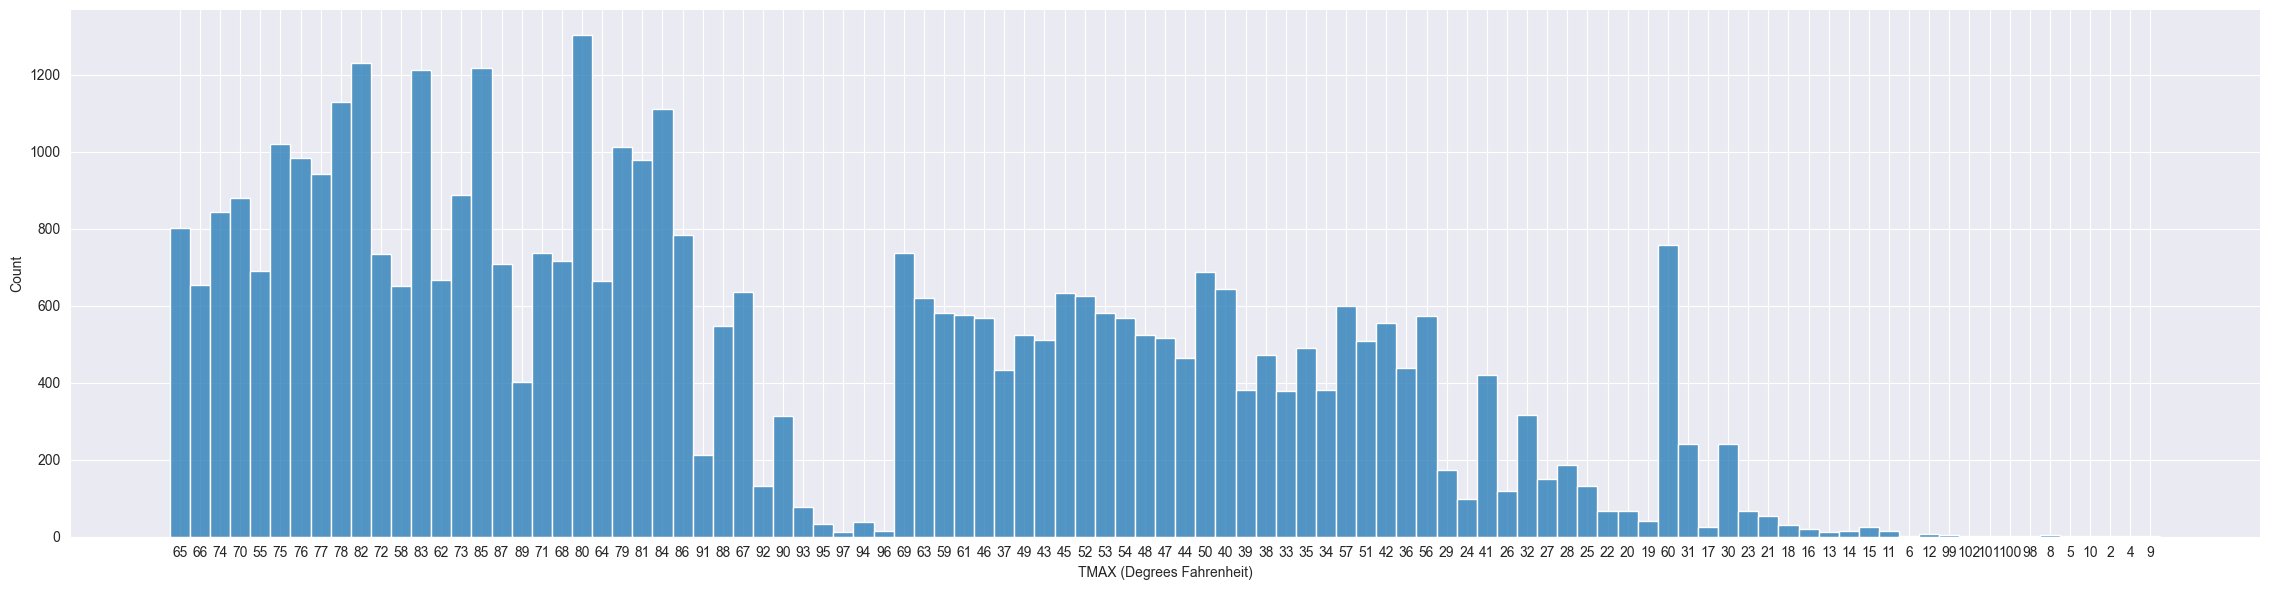

In [9]:
#Distribution plot
sns.displot(not_nan_rows_df, x="TMAX (Degrees Fahrenheit)", height=6, aspect=3.8)

In [10]:
df['TMAX (Degrees Fahrenheit)'].describe()

count    63230.000000
mean        64.793215
std         14.756715
min          2.000000
25%         58.000000
50%         67.000000
75%         74.000000
max        102.000000
Name: TMAX (Degrees Fahrenheit), dtype: float64

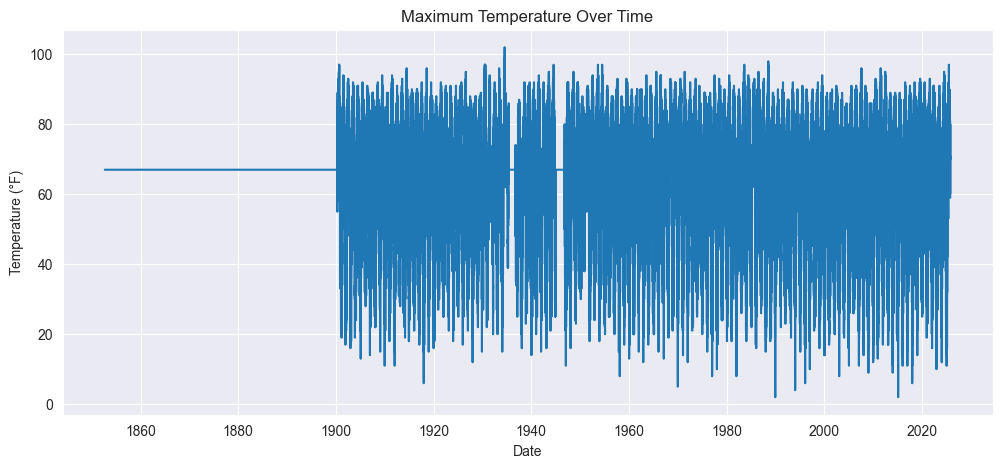

In [11]:
#Time Series
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['TMAX (Degrees Fahrenheit)'])
plt.title("Maximum Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.show()

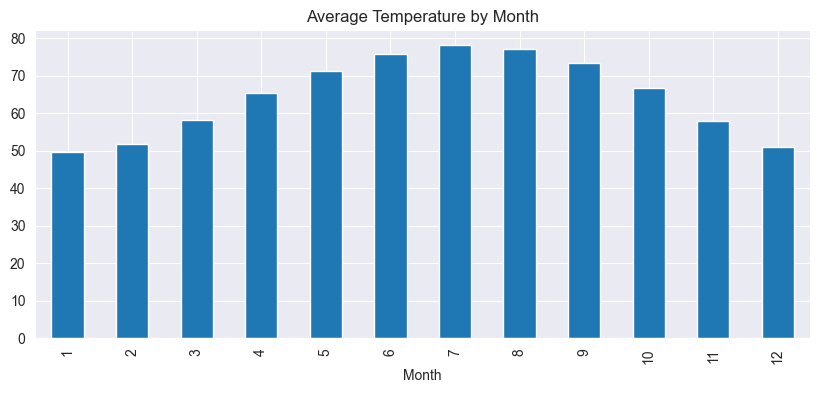

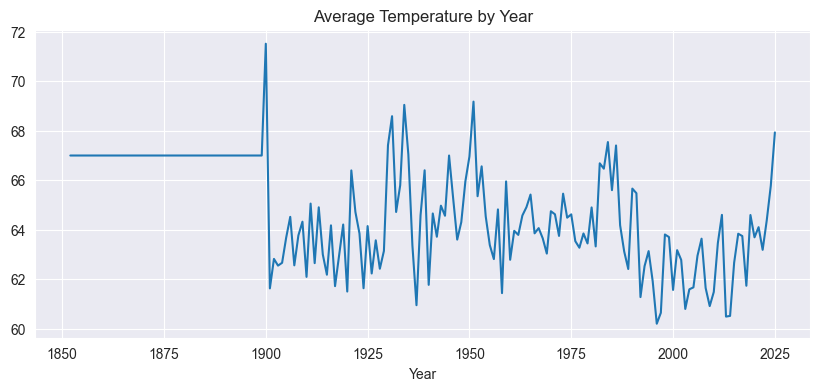

In [12]:
#Monthly and Yearly trends
monthly_avg = df.groupby('Month')['TMAX (Degrees Fahrenheit)'].mean()
yearly_avg = df.groupby('Year')['TMAX (Degrees Fahrenheit)'].mean()

# Plot monthly trend
monthly_avg.plot(kind='bar', title='Average Temperature by Month', figsize=(10,4))
plt.show()

# Plot yearly trend
yearly_avg.plot(kind='line', title='Average Temperature by Year', figsize=(10,4))
plt.show()


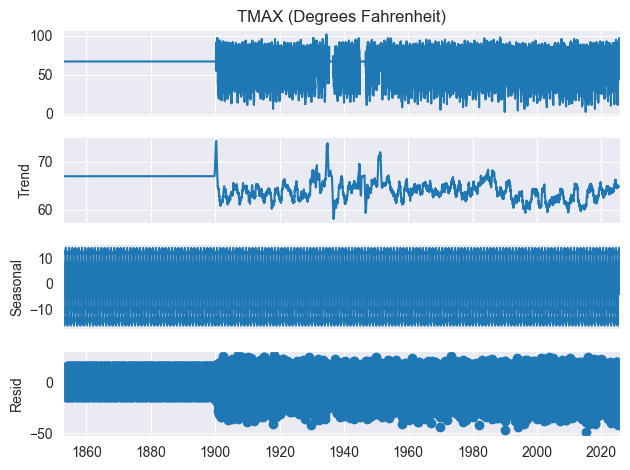

In [13]:
#Seasonal Decomposition
result = seasonal_decompose(df.set_index('Date')['TMAX (Degrees Fahrenheit)'], model='additive', period=365)
result.plot()
plt.show()

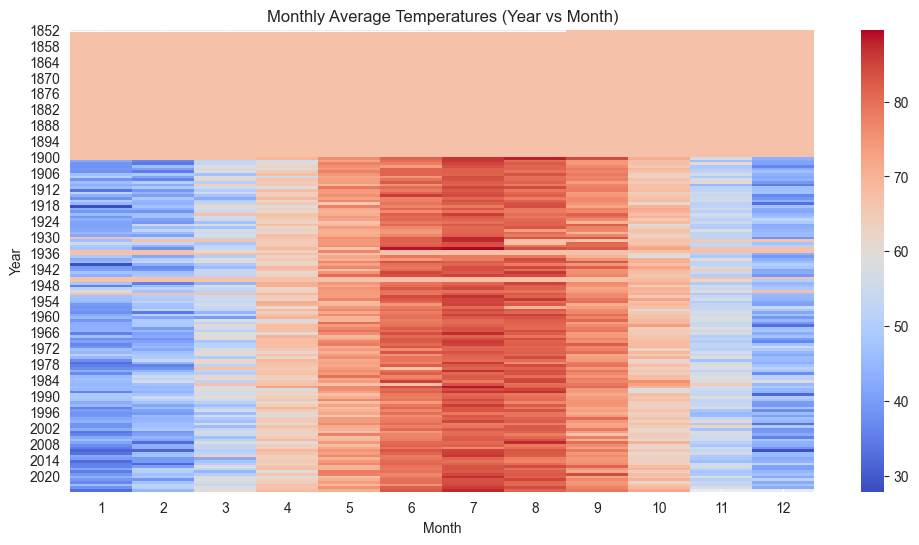

In [14]:
#Average temperature by month and year (Blue - cool and red - warm
pivot = df.pivot_table(values='TMAX (Degrees Fahrenheit)', index='Year', columns='Month', aggfunc='mean')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='coolwarm', annot=False)
plt.title("Monthly Average Temperatures (Year vs Month)")
plt.show()
#Visually shows warming/cooling trends over years and seasons

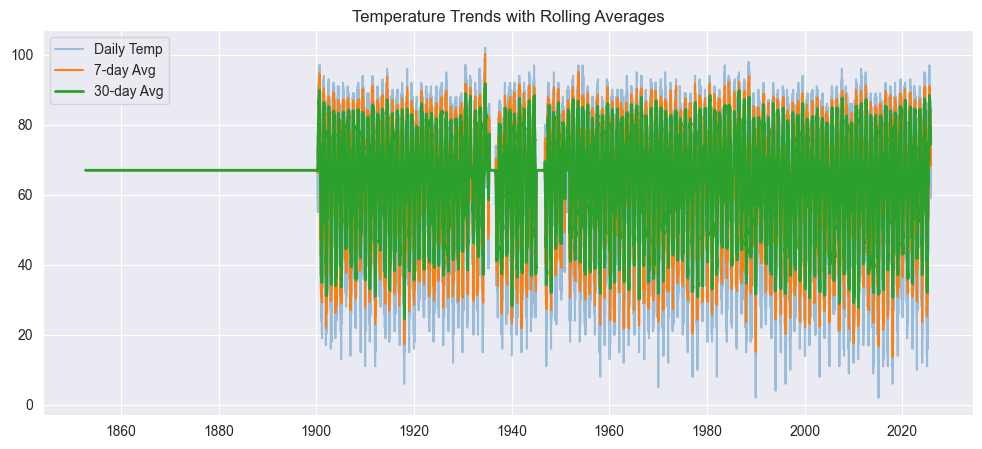

In [15]:
#Rolling Statistics Trend and Smoothing
df['Rolling_7d'] = df['TMAX (Degrees Fahrenheit)'].rolling(window=7).mean()
df['Rolling_30d'] = df['TMAX (Degrees Fahrenheit)'].rolling(window=30).mean()

plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['TMAX (Degrees Fahrenheit)'], alpha=0.4, label='Daily Temp')
plt.plot(df['Date'], df['Rolling_7d'], label='7-day Avg')
plt.plot(df['Date'], df['Rolling_30d'], label='30-day Avg', linewidth=2)
plt.legend()
plt.title("Temperature Trends with Rolling Averages")
plt.show()
#Shows short-term vs long-term variations

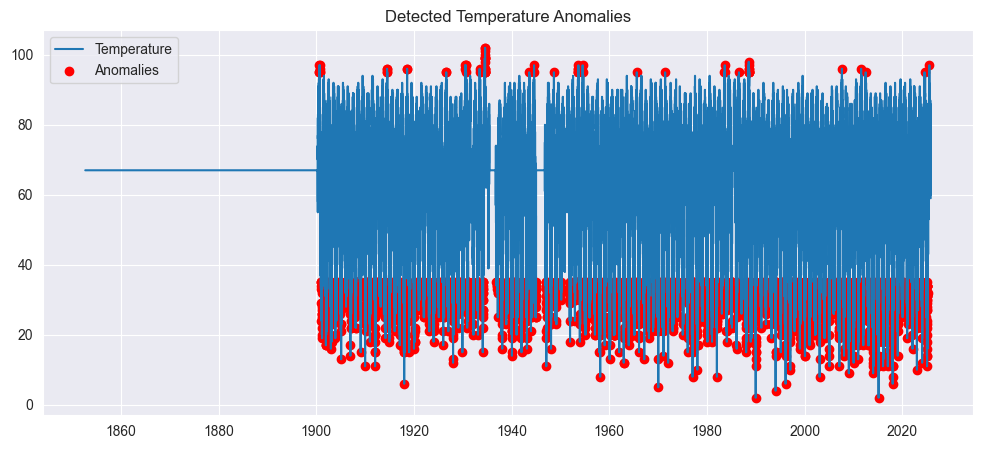

In [16]:
#Temperature Extremes & Anomalies
mean = df['TMAX (Degrees Fahrenheit)'].mean()
std = df['TMAX (Degrees Fahrenheit)'].std()
df['Anomaly'] = (df['TMAX (Degrees Fahrenheit)'] - mean).abs() > 2 * std

plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['TMAX (Degrees Fahrenheit)'], label='Temperature')
plt.scatter(df[df['Anomaly']]['Date'], df[df['Anomaly']]['TMAX (Degrees Fahrenheit)'], color='red', label='Anomalies')
plt.legend()
plt.title("Detected Temperature Anomalies")
plt.show()
#Detecting anomalies (extreme heat/cold)

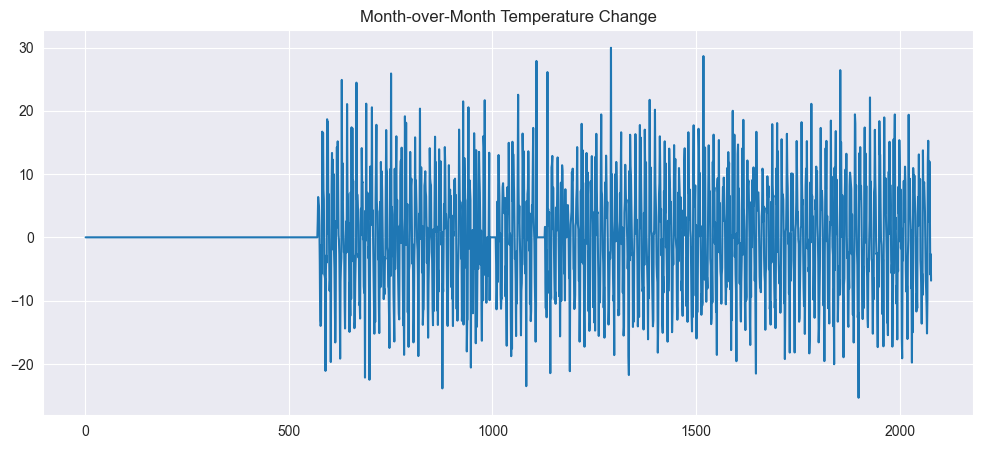

In [17]:
#Month-over-Month & Year-over-Year Change
monthly_mean = df.groupby(['Year','Month'])['TMAX (Degrees Fahrenheit)'].mean().reset_index()
monthly_mean['Prev_Month'] = monthly_mean['TMAX (Degrees Fahrenheit)'].shift(1)
monthly_mean['Change'] = monthly_mean['TMAX (Degrees Fahrenheit)'] - monthly_mean['Prev_Month']

plt.figure(figsize=(12,5))
plt.plot(monthly_mean['Change'])
plt.title("Month-over-Month Temperature Change")
plt.show()
#Shows climate variability - climate trend analysis

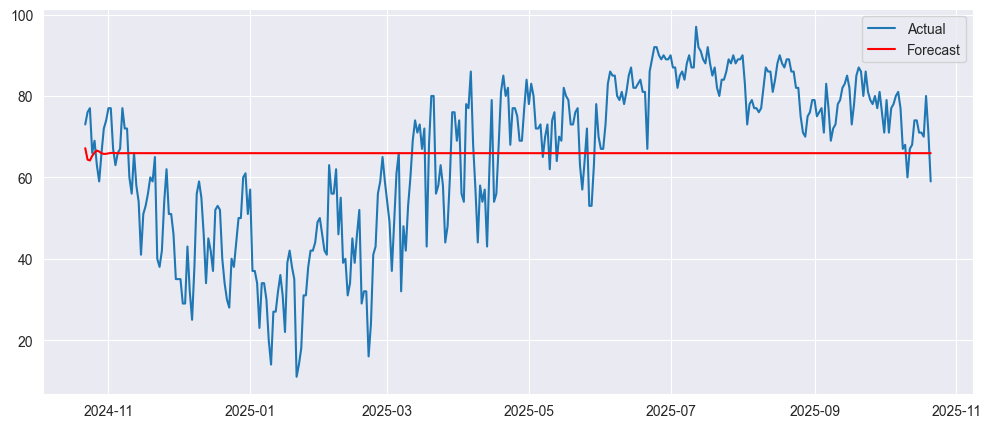

Test RMSE: 19.220883188541137


In [18]:
##ARIMA (Statistical)
# Split into train and test
train = df['TMAX (Degrees Fahrenheit)'][:-365]
test = df['TMAX (Degrees Fahrenheit)'][-365:]

# Fit ARIMA model
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
plt.figure(figsize=(12,5))
plt.plot(df['Date'][-365:], test, label='Actual')
plt.plot(df['Date'][-365:], forecast, label='Forecast', color='red')
plt.legend()
plt.show()

print("Test RMSE:", np.sqrt(mean_squared_error(test, forecast)))


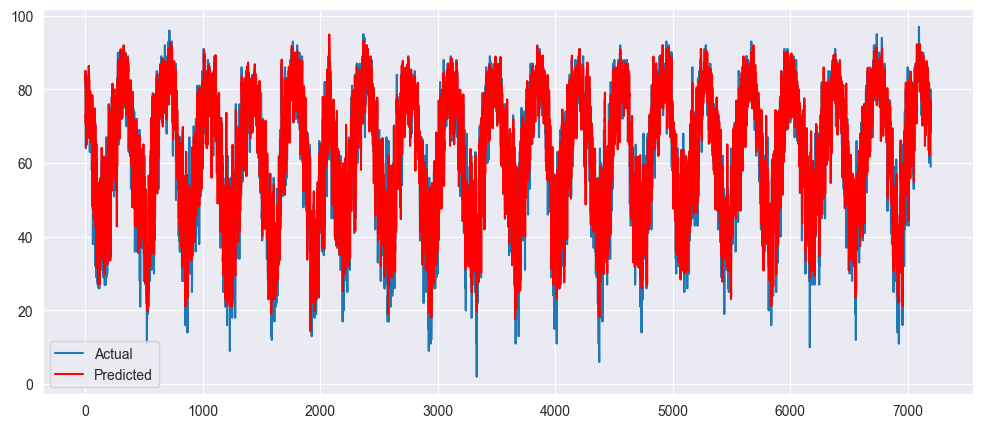

Test RMSE: 8.759668675192625


In [19]:
#Machine Learning (Regression)
# Create lag features
df['lag1'] = df['TMAX (Degrees Fahrenheit)'].shift(1)
df['lag2'] = df['TMAX (Degrees Fahrenheit)'].shift(2)
df['lag7'] = df['TMAX (Degrees Fahrenheit)'].shift(7)
df.dropna(inplace=True)

# Train-test split
X = df[['lag1', 'lag2', 'lag7']]
y = df['TMAX (Degrees Fahrenheit)']
train_size = int(len(X) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', color='red')
plt.legend()
plt.show()

print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

In [20]:
# Save RandomForestRegressor
dump(model, "model_rf.joblib")

['model_rf.joblib']

In [21]:
print(model.feature_names_in_)

['lag1' 'lag2' 'lag7']


# **FORECASTING**

1. Extract the last observed temperature values required for lag features.
2. Iteratively predict the next day's temperature using the model.
3. Append the predicted value to the input sequence for the next iteration.
4. Repeat for 30 days to generate the forecast.

In [22]:
# Load model
model = load("model_rf.joblib")

forecast_days = 30
last_known = df['TMAX (Degrees Fahrenheit)'].values.copy()
forecast = []

for _ in range(forecast_days):
    # Create input as DataFrame with correct column names
    input_features = pd.DataFrame({
        'lag1': [last_known[-1]],
        'lag2': [last_known[-2]],
        'lag7': [last_known[-7]]
    })

    next_value = model.predict(input_features)[0]
    forecast.append(next_value)
    last_known = np.append(last_known, next_value)

# Forecast DataFrame
forecast_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_days)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'forecast': forecast})

print(forecast_df)


         Date   forecast
0  2025-10-22  67.497000
1  2025-10-23  61.842667
2  2025-10-24  66.090000
3  2025-10-25  65.216000
4  2025-10-26  67.493952
5  2025-10-27  59.944667
6  2025-10-28  69.440000
7  2025-10-29  67.271405
8  2025-10-30  65.237167
9  2025-10-31  63.800833
10 2025-11-01  62.540000
11 2025-11-02  51.495000
12 2025-11-03  51.590000
13 2025-11-04  55.665333
14 2025-11-05  63.012500
15 2025-11-06  65.332500
16 2025-11-07  66.330000
17 2025-11-08  72.258333
18 2025-11-09  73.310000
19 2025-11-10  70.987071
20 2025-11-11  68.646667
21 2025-11-12  66.366988
22 2025-11-13  66.768837
23 2025-11-14  58.271667
24 2025-11-15  47.799500
25 2025-11-16  63.500000
26 2025-11-17  63.829333
27 2025-11-18  65.788333
28 2025-11-19  70.195000
29 2025-11-20  68.400143


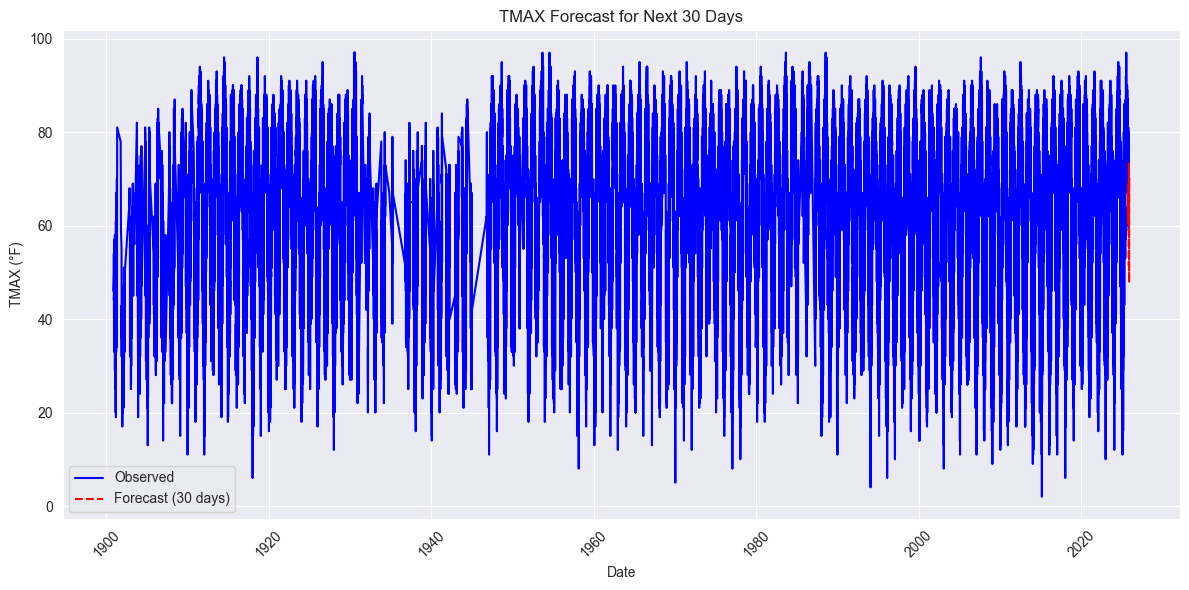

In [23]:
# Combine original data and forecast for plotting
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(df['Date'], df['TMAX (Degrees Fahrenheit)'], label='Observed', color='blue')

# Plot forecasted values
plt.plot(forecast_df['Date'], forecast_df['forecast'], label='Forecast (30 days)', color='red', linestyle='--')

# Formatting
plt.title('TMAX Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('TMAX (°F)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


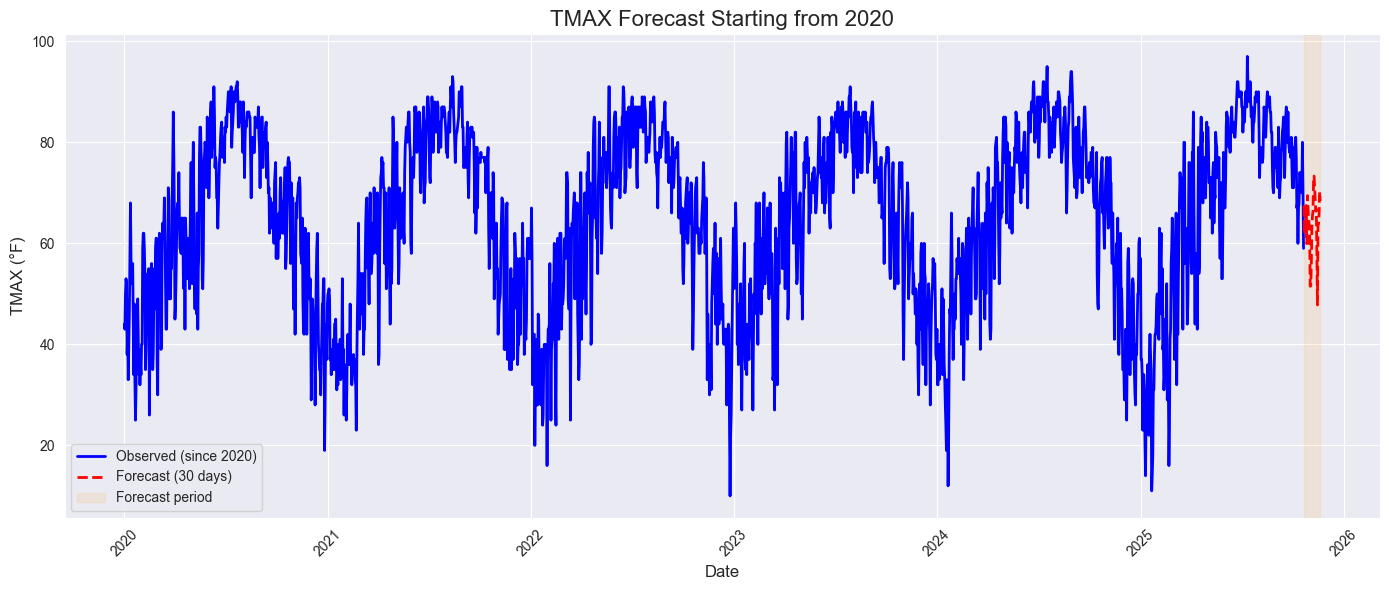

In [24]:
# Filter historical data starting from 2020
df_filtered = df[df['Date'] >= '2020-01-01']

# Combine historical and forecast data
all_dates = pd.concat([df_filtered['Date'], forecast_df['Date']])
all_values = pd.concat([df_filtered['TMAX (Degrees Fahrenheit)'], forecast_df['forecast']])

plt.figure(figsize=(14, 6))

# Plot historical data
plt.plot(df_filtered['Date'], df_filtered['TMAX (Degrees Fahrenheit)'], label='Observed (since 2020)', color='blue', linewidth=2)

# Plot forecasted values
plt.plot(forecast_df['Date'], forecast_df['forecast'], label='Forecast (30 days)', color='red', linestyle='--', linewidth=2)

# Shade the forecast area
plt.axvspan(forecast_df['Date'].iloc[0], forecast_df['Date'].iloc[-1], color='orange', alpha=0.1, label='Forecast period')

# Formatting
plt.title('TMAX Forecast Starting from 2020', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('TMAX (°F)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


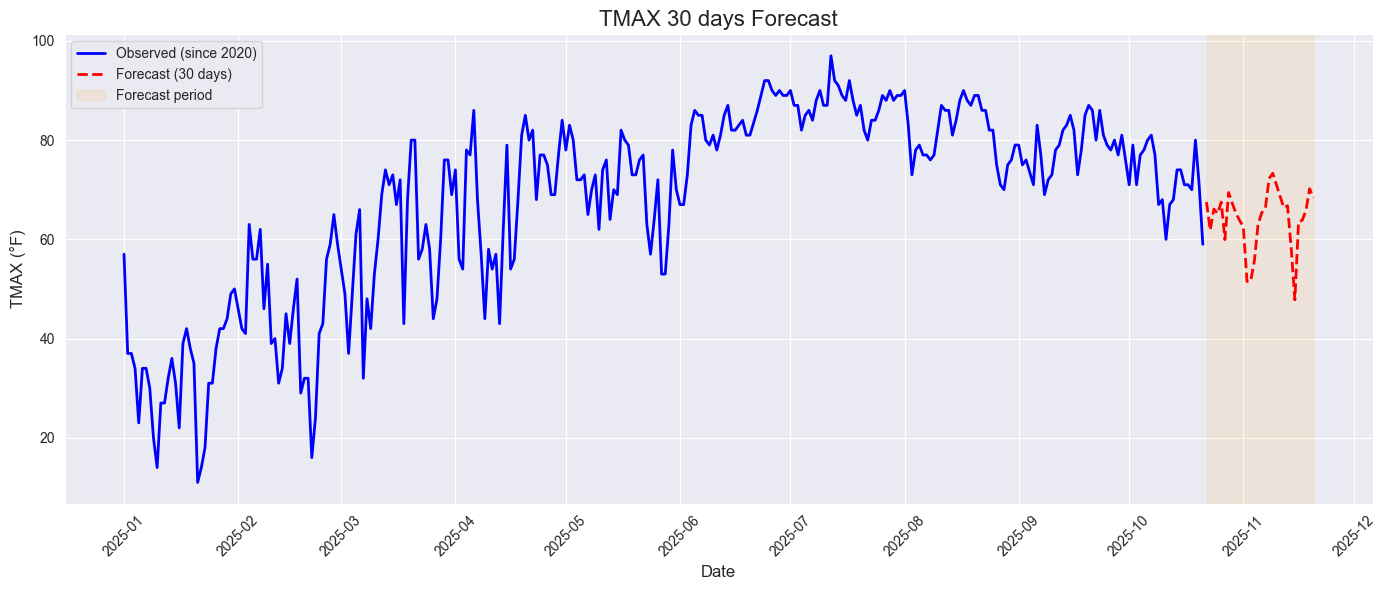

In [25]:
# Filter historical data starting from 2020
df_filtered = df[df['Date'] >= '2025-01-01']

# Combine historical and forecast data
all_dates = pd.concat([df_filtered['Date'], forecast_df['Date']])
all_values = pd.concat([df_filtered['TMAX (Degrees Fahrenheit)'], forecast_df['forecast']])

plt.figure(figsize=(14, 6))

# Plot historical data
plt.plot(df_filtered['Date'], df_filtered['TMAX (Degrees Fahrenheit)'], label='Observed (since 2020)', color='blue', linewidth=2)

# Plot forecasted values
plt.plot(forecast_df['Date'], forecast_df['forecast'], label='Forecast (30 days)', color='red', linestyle='--', linewidth=2)

# Shade the forecast area
plt.axvspan(forecast_df['Date'].iloc[0], forecast_df['Date'].iloc[-1], color='orange', alpha=0.1, label='Forecast period')

# Formatting
plt.title('TMAX 30 days Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('TMAX (°F)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
#Forecast Summary
forecast_values = forecast_df['forecast'].values
print(f"Minimum predicted TMAX: {np.min(forecast_values):.2f}°F")
print(f"Maximum predicted TMAX: {np.max(forecast_values):.2f}°F")
print(f"Average predicted TMAX: {np.mean(forecast_values):.2f}°F")

Minimum predicted TMAX: 47.80°F
Maximum predicted TMAX: 73.31°F
Average predicted TMAX: 64.20°F


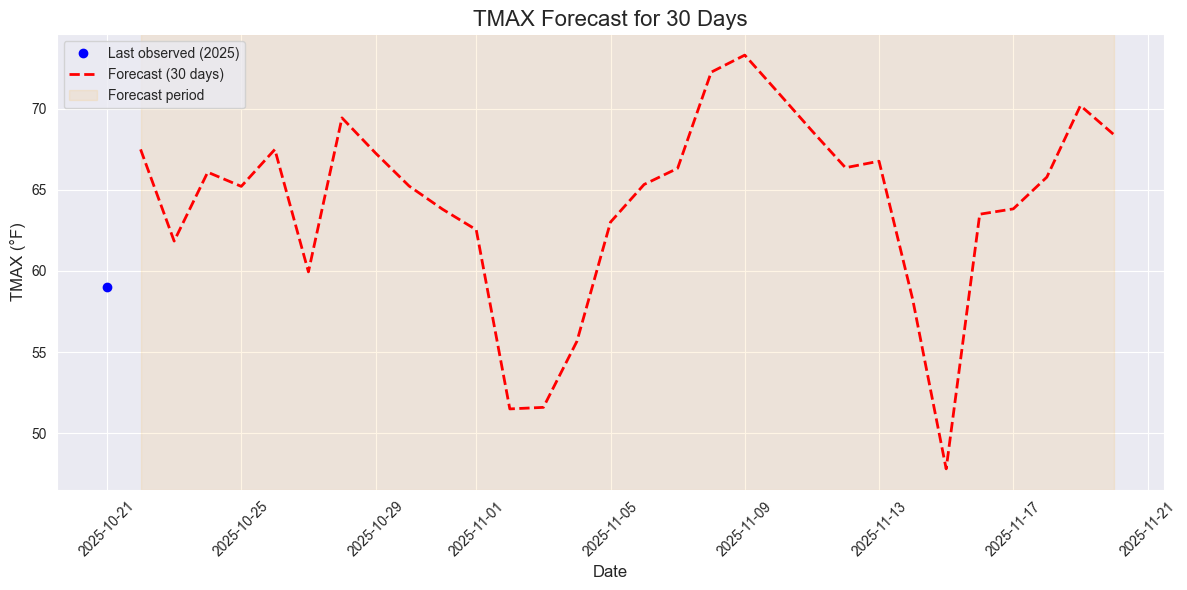

In [27]:
#Forecast Plot
# Last observed point
last_point = df[df['Date'] == df['Date'].max()][['Date', 'TMAX (Degrees Fahrenheit)']]

plt.figure(figsize=(12, 6))

# Plot last observed point
plt.plot(last_point['Date'], last_point['TMAX (Degrees Fahrenheit)'], 'bo', label='Last observed (2025)')

# Plot forecasted values
plt.plot(forecast_df['Date'], forecast_df['forecast'], 'r--', linewidth=2, label='Forecast (30 days)')

# Shade forecast period
plt.axvspan(forecast_df['Date'].iloc[0], forecast_df['Date'].iloc[-1], color='orange', alpha=0.1, label='Forecast period')

plt.title('TMAX Forecast for 30 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('TMAX (°F)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()